# Task 7.2: Understanding Providers and Monitoring Jobs

This notebook provides a practical guide to the Qiskit provider model, which includes the `Provider`, `Backend`, and `Job` classes.

**Goal:** To understand how these components work together, we will build a simple, **custom in-memory backend**. This "fake" backend will not run real quantum computations but will correctly implement the Qiskit interfaces, allowing us to see the full workflow of submitting a job and retrieving a result.

## Objective 1: The Provider, Backend, and Job Abstract Classes

The Qiskit provider model is a framework for defining how Qiskit interacts with different execution resources (backends).

*   **`Provider`:** The entry point. It manages and provides access to a group of backends (e.g., `qiskit-ibm-provider` gives access to IBM's backends).
*   **`BackendV2`:** The modern interface for a backend. It describes the backend's capabilities (its `target`) and has a `.run()` method to execute circuits.
*   **`Job`:** The object returned by `backend.run()`. It represents a submitted job and is used to monitor its status (`.status()`) and retrieve the final result (`.result()`).

### Step 1: Implementing a Custom `Job`

We'll start by creating a simple `MyJob` class that simulates a job's lifecycle. It will pretend to be "RUNNING" for a short time and then return a pre-defined, fake result.

In [1]:
import time
import uuid
from qiskit.providers import JobV1 as Job, JobStatus, JobError
from qiskit.result import Result

class MyJob(Job):
    """A simple, in-memory job class for demonstration."""
    def __init__(self, backend, job_id, circuit):
        super().__init__(backend, job_id)
        self._status = JobStatus.QUEUED
        self._circuit = circuit
        self._result = self._create_fake_result()
        print(f"-> Job {self._job_id} created for circuit '{self._circuit.name}'.")

    def _create_fake_result(self):
        """Creates a static, fake result object."""
        fake_counts = {'00': 512, '11': 512} # Simulate a perfect Bell state
        results_dict = {
            'backend_name': self._backend.name,
            'backend_version': self._backend.version,
            'job_id': self._job_id,
            'qobj_id': str(uuid.uuid4()),
            'success': True,
            'results': [
                {
                    'shots': 1024,
                    'success': True,
                    'header': {'name': self._circuit.name},
                    'data': {'counts': fake_counts}
                }
            ]
        }
        return Result.from_dict(results_dict)

    def submit(self):
        """Simulates submitting the job. It will move to RUNNING then DONE."""
        self._status = JobStatus.RUNNING
        print(f"-> Job {self._job_id} is now {self.status().name}.")
        # Simulate some execution time
        time.sleep(0.5)
        self._status = JobStatus.DONE
        print(f"-> Job {self._job_id} is now {self.status().name}.")

    def result(self):
        """Return the fake result."""
        if self._status is not JobStatus.DONE:
            raise JobError("Job has not completed yet.")
        return self._result

    def status(self):
        """Return the current job status."""
        return self._status

print("MyJob class defined successfully!")

MyJob class defined successfully!


### Step 2: Implementing a Custom `BackendV2`

Next, we'll create `MyBackend`. Its main job is to define its capabilities (the `target`) and a `.run()` method that returns our `MyJob` object.

**Important:** `BackendV2` requires implementing the `_default_options()` method, which defines default options for the backend.

In [2]:
from qiskit.circuit import Measure, Reset, Parameter
from qiskit.circuit.library import SXGate, CXGate, UGate
from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target

class MyBackend(BackendV2):
    """A simple custom backend that returns our fake MyJob."""
    def __init__(self, provider=None):
        super().__init__(name="my_custom_backend", backend_version="1.0")
        self._provider = provider
        
        # --- Define the Backend's Target ---
        # The target describes exactly what gates and operations are supported.
        self._target = Target()
        theta = Parameter("theta")
        phi = Parameter("phi")
        lam = Parameter("lam")
        
        # Add supported instructions with their properties (on all qubits 0-4)
        self._target.add_instruction(UGate(theta, phi, lam), {(i,): None for i in range(5)})
        self._target.add_instruction(SXGate(), {(i,): None for i in range(5)})
        self._target.add_instruction(CXGate(), {(0, 1): None, (1, 2): None, (2, 3): None, (3, 4): None})
        self._target.add_instruction(Measure(), {(i,): None for i in range(5)})
        self._target.add_instruction(Reset(), {(i,): None for i in range(5)})
        
        print("-> MyBackend initialized.")

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return 1
    
    @classmethod
    def _default_options(cls):
        """Return default options for this backend."""
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        """'Run' a circuit by creating and submitting a MyJob instance."""
        job_id = str(uuid.uuid4())
        job = MyJob(backend=self, job_id=job_id, circuit=circuit)
        job.submit()
        return job

print("MyBackend class defined successfully!")

MyBackend class defined successfully!


### Step 3: Implementing a Custom `Provider`

Finally, the `MyProvider` class acts as the entry point to get our backend. We'll create a simple provider class without inheriting from deprecated base classes.

In [3]:
class MyProvider:
    """A simple provider that gives access to MyBackend."""
    def __init__(self):
        self._backends = {"my_custom_backend": MyBackend(provider=self)}
        print("-> MyProvider initialized.")
    
    def get_backend(self, name=None):
        """Get a backend by name."""
        if name is None:
            # Return the first backend if no name specified
            return list(self._backends.values())[0]
        if name in self._backends:
            return self._backends[name]
        raise KeyError(f"Backend '{name}' not found")
        
    def backends(self, name=None, **kwargs):
        """Return the list of available backends."""
        if name:
            return [self._backends[name]] if name in self._backends else []
        return list(self._backends.values())

print("MyProvider class defined successfully!")

MyProvider class defined successfully!


## Putting It All Together: A Full Workflow Example

Now we can use our custom provider and backend just like any other Qiskit provider.

In [ ]:
# 1. Instantiate our custom provider
print("\n" + "="*60)
print("Step 1: Creating Provider")
print("="*60)
my_provider = MyProvider()


Step 1: Creating Provider
-> MyBackend initialized.
-> MyProvider initialized.


In [5]:
# 2. Get our custom backend from the provider
print("\n" + "="*60)
print("Step 2: Getting Backend")
print("="*60)
my_backend = my_provider.get_backend("my_custom_backend")
print(f"Backend name: {my_backend.name}")
print(f"Backend version: {my_backend.version}")
print(f"Max circuits: {my_backend.max_circuits}")
print(f"Default shots: {my_backend.options.shots}")


Step 2: Getting Backend
Backend name: my_custom_backend
Backend version: 2
Max circuits: 1
Default shots: 1024



Step 3: Creating Circuit

Original Circuit:
     ┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1 


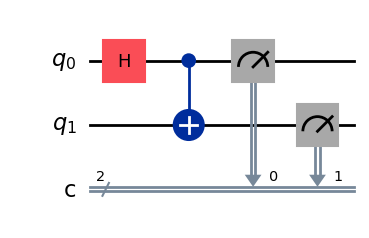

In [6]:
# 3. Create a circuit we want to run
print("\n" + "="*60)
print("Step 3: Creating Circuit")
print("="*60)
bell_circuit = QuantumCircuit(2, 2, name="bell_state")
bell_circuit.h(0)
bell_circuit.cx(0, 1)
bell_circuit.measure([0, 1], [0, 1])

print("\nOriginal Circuit:")
print(bell_circuit)
bell_circuit.draw('mpl')


Step 4: Transpiling Circuit

Transpiled Circuit (using backend's basis gates):
         ┌────────────┐     ┌─┐   
q_0 -> 1 ┤ U(π/2,0,π) ├──■──┤M├───
         └────────────┘┌─┴─┐└╥┘┌─┐
q_1 -> 2 ──────────────┤ X ├─╫─┤M├
                       └───┘ ║ └╥┘
    c: 2/════════════════════╩══╩═
                             0  1 


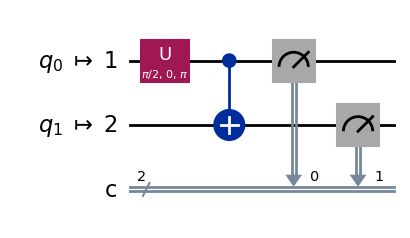

In [7]:
# 4. Transpile the circuit for our backend's target
# This step is crucial to ensure the circuit only uses gates our backend supports.
print("\n" + "="*60)
print("Step 4: Transpiling Circuit")
print("="*60)
transpiled_circuit = transpile(bell_circuit, backend=my_backend)
print("\nTranspiled Circuit (using backend's basis gates):")
print(transpiled_circuit)
transpiled_circuit.draw('mpl')

### Submitting the Job and Monitoring Status

The `.run()` method returns our `MyJob` object. We can use it to check the status and get the result.

In [8]:
# 5. Run the transpiled circuit on our backend
print("\n" + "="*60)
print("Step 5: Running Job")
print("="*60)
job = my_backend.run(transpiled_circuit)

# 6. Check the final status
print(f"\nFinal job status: {job.status()}")
print(f"Job ID: {job.job_id()}")


Step 5: Running Job
-> Job aa8172d2-c67f-4673-8e0f-66c3eee5861a created for circuit 'bell_state'.
-> Job aa8172d2-c67f-4673-8e0f-66c3eee5861a is now RUNNING.
-> Job aa8172d2-c67f-4673-8e0f-66c3eee5861a is now DONE.

Final job status: JobStatus.DONE
Job ID: aa8172d2-c67f-4673-8e0f-66c3eee5861a


In [9]:
# 7. Get the result
print("\n" + "="*60)
print("Step 6: Retrieving Results")
print("="*60)
result = job.result()
counts = result.get_counts()
print(f"\nResulting counts: {counts}")
print(f"\nResult metadata:")
print(f"  Backend: {result.backend_name}")
print(f"  Job ID: {result.job_id}")
print(f"  Success: {result.success}")


Step 6: Retrieving Results

Resulting counts: {'00': 512, '11': 512}

Result metadata:
  Backend: my_custom_backend
  Job ID: aa8172d2-c67f-4673-8e0f-66c3eee5861a
  Success: True



Histogram of results:


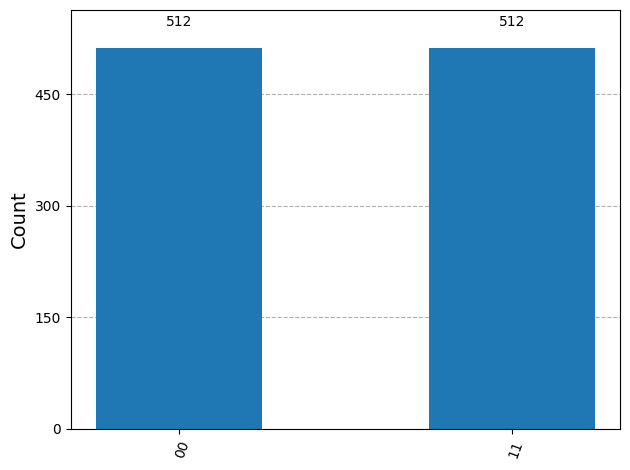

In [10]:
# 8. Plot the histogram from the result
from qiskit.visualization import plot_histogram

print("\nHistogram of results:")
plot_histogram(counts)

## Understanding the Target

The `Target` object is crucial for transpilation. Let's examine what our backend reports as its supported operations.

In [11]:
# Get the target from our backend
target = my_backend.target

print("Backend Target Information:")
print(f"  Number of qubits: {target.num_qubits}")
print(f"\nSupported operations:")
for operation in target.operations:
    print(f"  - {operation}")

print(f"\nSupported instructions for each operation:")
for instruction_name in target.operation_names:
    qargs = target.qargs_for_operation_name(instruction_name)
    print(f"  {instruction_name}: {len(qargs)} configurations")

Backend Target Information:
  Number of qubits: 5

Supported operations:
  - Instruction(name='u', num_qubits=1, num_clbits=0, params=[Parameter(theta), Parameter(phi), Parameter(lam)])
  - Instruction(name='sx', num_qubits=1, num_clbits=0, params=[])
  - Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
  - Instruction(name='measure', num_qubits=1, num_clbits=1, params=[])
  - Instruction(name='reset', num_qubits=1, num_clbits=0, params=[])

Supported instructions for each operation:
  u: 5 configurations
  sx: 5 configurations
  cx: 4 configurations
  measure: 5 configurations
  reset: 5 configurations


## Objective 2: JobStatus Enumeration

The `JobStatus` enumeration represents the various states a job can be in during its lifecycle. Let's examine all possible states.

In [12]:
from qiskit.providers import JobStatus

print("All possible JobStatus values:")
print("="*60)
for status in JobStatus:
    print(f"  {status.name:15} - Value: {status.value}")

print("\nTypical Job Lifecycle:")
print("  INITIALIZING → QUEUED → VALIDATING → RUNNING → DONE")
print("\nPossible terminal states:")
print("  - DONE: Job completed successfully")
print("  - ERROR: Job encountered an error")
print("  - CANCELLED: Job was cancelled by user")

All possible JobStatus values:
  INITIALIZING    - Value: job is being initialized
  QUEUED          - Value: job is queued
  VALIDATING      - Value: job is being validated
  RUNNING         - Value: job is actively running
  CANCELLED       - Value: job has been cancelled
  DONE            - Value: job has successfully run
  ERROR           - Value: job incurred error

Typical Job Lifecycle:
  INITIALIZING → QUEUED → VALIDATING → RUNNING → DONE

Possible terminal states:
  - DONE: Job completed successfully
  - ERROR: Job encountered an error
  - CANCELLED: Job was cancelled by user


## Objective 3: Sessions (Runtime-Specific Concept)

**`Session`** is a concept from `qiskit-ibm-runtime` for managing a dedicated connection to a backend to run multiple jobs efficiently. 

### Key Points:

- Sessions are **specific to IBM Quantum Runtime** services
- They allow you to reserve backend time for multiple jobs
- They reduce queue times for subsequent jobs in the same session
- Our custom `BackendV2` implementation doesn't support sessions (it's not a runtime service)

### Session Attributes:
- `service`: The QiskitRuntimeService instance
- `session_id`: Unique identifier for the session

### Session Methods:
- `backend()`: Get the backend for the session
- `cancel()`: Cancel all jobs in the session
- `close()`: Close the session
- `details()`: Get session details
- `from_id()`: Create session from existing ID
- `status()`: Get session status
- `usage()`: Get resource usage statistics

In [13]:
# Example of how Sessions would be used (requires IBM Quantum account)
print("Example Session Usage (Cloud-only):")
print("="*60)
print("""
# With IBM Quantum Runtime:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

# Create a session to run multiple jobs
with Session(service=service, backend=backend) as session:
    sampler = SamplerV2(session=session)
    
    # Run multiple jobs within the same session
    job1 = sampler.run([circuit1])
    job2 = sampler.run([circuit2])
    job3 = sampler.run([circuit3])
    
    # Get results
    result1 = job1.result()
    result2 = job2.result()
    result3 = job3.result()
    
    # Check session info
    print(f"Session ID: {session.session_id}")
    print(f"Session status: {session.status()}")
    print(f"Session usage: {session.usage()}")

# Session automatically closes when exiting the 'with' block
""")

Example Session Usage (Cloud-only):

# With IBM Quantum Runtime:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

# Create a session to run multiple jobs
with Session(service=service, backend=backend) as session:
    sampler = SamplerV2(session=session)

    # Run multiple jobs within the same session
    job1 = sampler.run([circuit1])
    job2 = sampler.run([circuit2])
    job3 = sampler.run([circuit3])

    # Get results
    result1 = job1.result()
    result2 = job2.result()
    result3 = job3.result()

    # Check session info
    print(f"Session ID: {session.session_id}")
    print(f"Session status: {session.status()}")
    print(f"Session usage: {session.usage()}")

# Session automatically closes when exiting the 'with' block



## Summary

In this notebook, we covered:

1. **The Provider Model**:
   - Built a custom `Provider` to manage backends
   - Implemented a custom `BackendV2` with a defined `Target`
   - Created a custom `Job` class to handle job lifecycle
   - Implemented the required `_default_options()` method

2. **Complete Workflow**:
   - Created a quantum circuit
   - Transpiled it for our backend's basis gates
   - Submitted a job and monitored its status
   - Retrieved and visualized results

3. **JobStatus**: Learned about the enumeration representing job states

4. **Sessions**: Understood that sessions are runtime-specific features for efficient multi-job execution

This hands-on approach demonstrates how Qiskit's provider model creates a flexible, extensible framework for integrating various quantum computing backends!